https://www.kaggle.com/c/santander-customer-transaction-prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
# plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

### 1. Load data

In [3]:
df_train = pd.read_csv('data/train.csv')

In [4]:
df_test = pd.read_csv('data/test.csv')

### 2. Check the data

In [5]:
df_train.shape

(200000, 202)

In [6]:
df_test.shape

(200000, 201)

In [7]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


#### * Check missing value

In [8]:
df_nan_train = pd.DataFrame(df_train.isnull().sum(),columns=['n_nan'])
df_nan_train.reset_index(inplace=True)
df_nan_train.rename(columns={'index':'column'},inplace=True)
df_nan_train['nan_percent'] = df_nan_train['n_nan']/len(df_nan_train)

In [12]:
df_nan_train[df_nan_train['nan_percent']>0]

,column,n_nan,nan_percent


In [13]:
df_nan_test = pd.DataFrame(df_test.isnull().sum(),columns=['n_nan'])
df_nan_test.reset_index(inplace=True)
df_nan_test.rename(columns={'index':'column'},inplace=True)
df_nan_test['nan_percent'] = df_nan_test['n_nan']/len(df_nan_test)

In [14]:
df_nan_test[df_nan_test['nan_percent']>0]

,column,n_nan,nan_percent


#### No missing values in both training set and test set

#### \* Check features (categorical or numeric?)

In [15]:
df_train.select_dtypes(include=['int', 'float']).columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [16]:
df_train.select_dtypes(exclude=['int', 'float']).columns

Index(['ID_code', 'target'], dtype='object')

#### The data only contain numeric features.

#### \* Check the balance of targets

In [17]:
import seaborn as sns

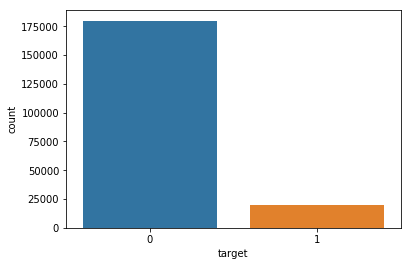

In [18]:
ax = sns.countplot(df_train['target'],label="Count") 

In [19]:
df_train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

#### There are much more negatives than positives in the training set. 

### 3. Feature selection
#### \* Check correlation between features (Paired correlation)

In [20]:
from scipy.stats.stats import pearsonr
import itertools

In [21]:
correlations = {}
for col_a, col_b in itertools.combinations(["var_{}".format(i) for i in range(200)], 2):
    correlations[col_a + '_' + col_b] = pearsonr(df_train.loc[:, col_a], df_train.loc[:, col_b])

In [23]:
df_corr = pd.DataFrame.from_dict(correlations, orient='index')
df_corr.columns = ['PCC', 'p-value']

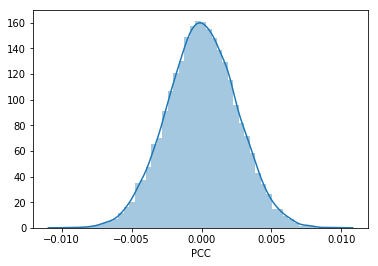

In [24]:
sns.distplot(df_corr['PCC'])

In [25]:
df_corr[['PCC']].describe()

,PCC
count,19900.000000
mean,0.000028
std,0.002493
min,-0.009844
25%,-0.001640
50%,0.000018
75%,0.001723
max,0.009714


#### It seems all the features are not correlated to each other.

#### \* How many features do we need to build model? 

In [26]:
from sklearn.metrics import roc_auc_score, recall_score,precision_score,accuracy_score,f1_score,matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV

C:\Anaconda3\Lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
## it can take several hours to run.
rfecv = RFECV(estimator=RandomForestClassifier(), step=3, min_features_to_select=20, cv=StratifiedKFold(3),scoring='roc_auc')
rfecv.fit(df_train[["var_{}".format(i) for i in range(200)]], df_train['target'])
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 68


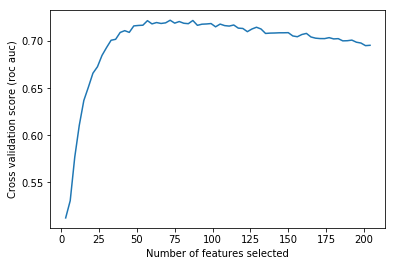

In [27]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc auc)")
## since we choose step - 3, so each step we add 3 features instead of 1. That's why we need to mutiply by 3 in x axis 
plt.plot([i*3 for i in list(range(1, len(rfecv.grid_scores_) + 1))], rfecv.grid_scores_)
plt.show()

#### 68 features seems reasonalble. 

#### \* Feature selection with tree based models

In [27]:
hasattr(RandomForestClassifier(), 'feature_importances_')

False

In [28]:
## Plot top n significant features 
## copyright to: https://www.kaggle.com/grfiv4/plotting-feature-importances#
## Thanks for sharing! It's super useful and handy!
def plot_feature_importances(clf, X_train, y_train, 
                             top_n=20, figsize=(20,10),title="Feature Importances"):
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
    
    
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
    feat_imp_plot = feat_imp.head(top_n)
    feat_imp_plot.sort_values(by='importance', inplace=True)
    feat_imp_plot = feat_imp_plot.set_index('feature', drop=True)
    feat_imp_plot.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    return feat_imp

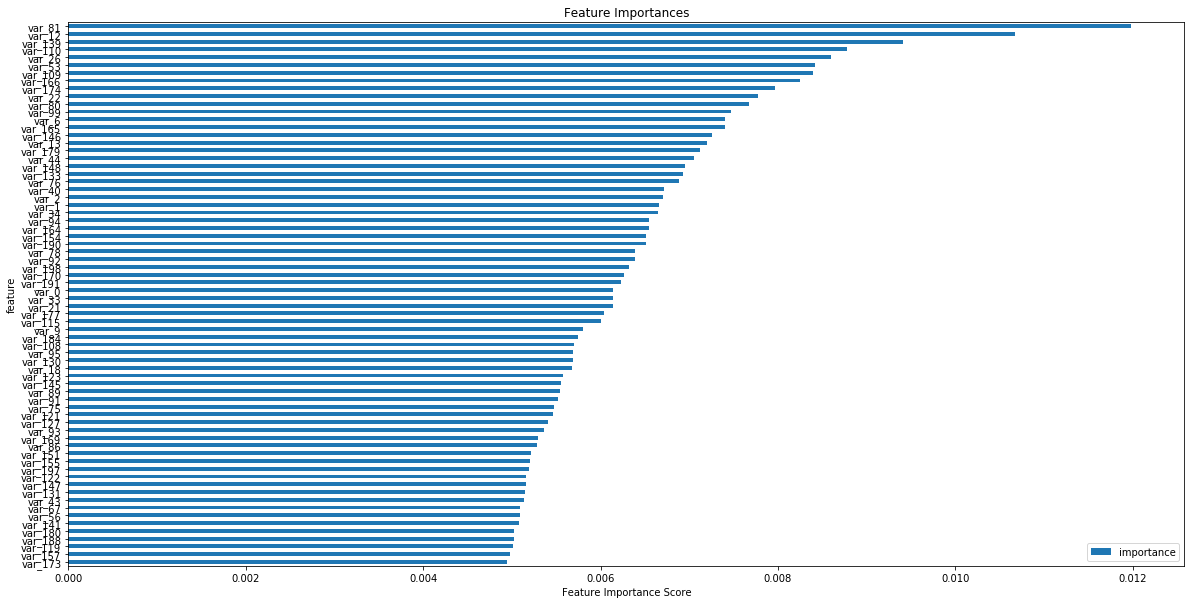

In [29]:
df_feat_rf = plot_feature_importances(RandomForestClassifier(), df_train[["var_{}".format(i) for i in range(200)]],df_train['target'],top_n=70)

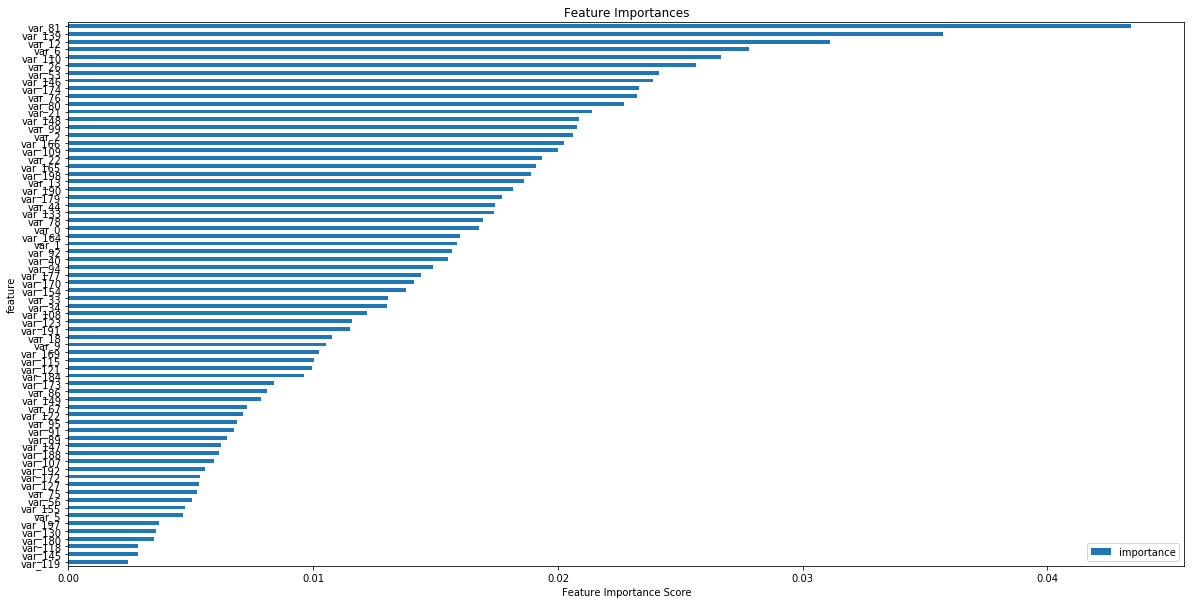

In [30]:
df_feat_gb = plot_feature_importances(GradientBoostingClassifier(), df_train[["var_{}".format(i) for i in range(200)]],df_train['target'],top_n=70)

#### \* Plot out top few features.

In [31]:
important_feats = ['var_81','var_12','var_139','var_110','var_26']

In [38]:
df_train['target'].unique()

array([0, 1], dtype=int64)

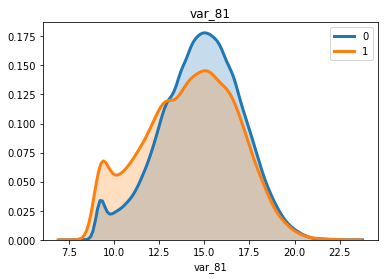

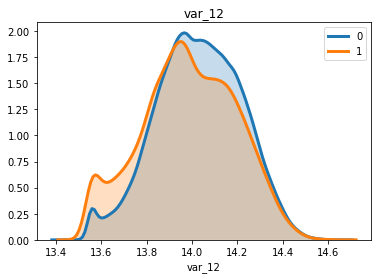

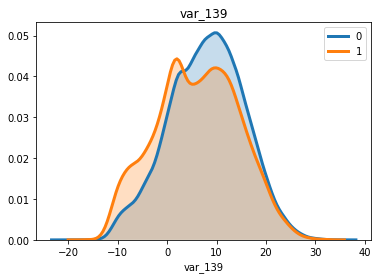

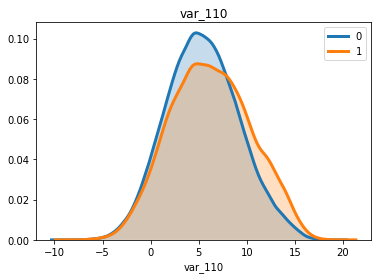

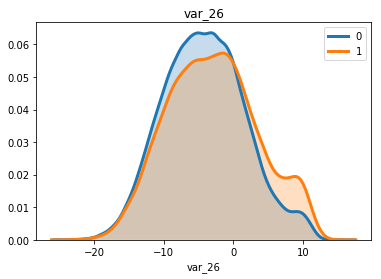

In [41]:
k=0
for var in important_feats:
    plt.figure(k)
    for i in [0,1]:
        sns.distplot(df_train[var][df_train['target']==i], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, 
                      label = i)
    plt.title(var)
    k+=1

#### There are some spikes in the distribution of the important features. 